# Regression

### Linear Regression

### Linear Model


线性假设是指目标（房屋价格）可以表示为特征（面积和房龄）的加权和，如下面的式子：

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$
<br>

其中，$w_{\mathrm{area}}$和$w_{\mathrm{age}}$
称为*权重*（weight），权重决定了每个特征对我们预测值的影响。<br><br>
$b$称为*偏置*（bias）、*偏移量*（offset）或*截距*（intercept）。
偏置是指当所有特征都取值为0时，预测值应该为多少。<br><br>
即使现实中不会有任何房子的面积是0或房龄正好是0年，我们仍然需要偏置项。
如果没有偏置项，我们模型的表达能力将受到限制。

线性模型的优点是易于理解和解释，缺点是易受到噪声影响。
如果数据中存在大量噪声，线性模型的预测结果可能不准确。
此外，线性模型对非线性关系的建模能力有限。


$单个样本操作$
$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$

$多个样本操作$
$$\hat{\mathbf{y}} = \mathbf{X} \mathbf{w} + b.$$
这个过程中的求和将使用广播机制

虽然我们相信给定$\mathbf{x}$预测$y$的最佳模型会是线性的，
但我们很难找到一个有$n$个样本的真实数据集，其中对于所有的$1 \leq i \leq n$，$y^{(i)}$完全等于$\mathbf{w}^\top \mathbf{x}^{(i)}+b$。
无论我们使用什么手段来观察特征$\mathbf{X}$和标签$\mathbf{y}$，
都可能会出现少量的观测误差。
因此，即使确信特征与标签的潜在关系是线性的，
我们也会加入一个噪声项来考虑观测误差带来的影响。

### Loss Function
$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

最小化损失函数的过程就是：

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

我们假设了观测中包含噪声，其中噪声服从正态分布。
噪声正态分布如下式:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon,$$

其中，$\epsilon \sim \mathcal{N}(0, \sigma^2)$。

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的*似然*（likelihood）

# Others

### Normal Distribution

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

In [1]:
%matplotlib inline
import math
import time
import torch
from d2l import torch as d2l
import numpy as np

In [2]:
def normalDistribution(x, mu, sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    res = p * np.exp(-0.5 / sigma**2 * (x - mu)**2)
    return res

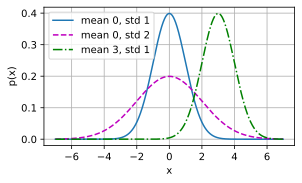

In [3]:
# visualization of normal distribution
x = np.arange(-7,7,0.01)

params = [[0,1],[0,2],[3,1]]
d2l.plot(x, [normalDistribution(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

$虽然飞机可能受到鸟类的启发，$<br>$但几个世纪以来，鸟类学并不是航空创新的主要驱动力。$
<br>
$同样地，如今在深度学习中的灵感同样$<br>$或更多地来自数学、统计学和计算机科学.$

# Realization of Linear Regression

In [4]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [5]:
def synthetic_data(w,b,num_examples): #@save
    
    """Generate y = Xw + b + noise."""
    
    X = torch.normal(0,1,(num_examples,len(w)))
    # 生成输入数据
    # torch.normal(mean,std,size(rowNumber,colNumber))

    y = torch.matmul(X,w)+b
    # 计算输出数据
    # matmul = matrix multiplication

    y += torch.normal(0,0.01,y.shape)
    # 添加噪声

    return X,y.reshape((-1,1))

In [6]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.3620, 1.7331]) 
label: tensor([-0.9777])


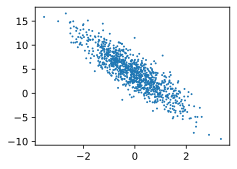

In [7]:
d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

In [8]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #随机抽样
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i+batch_size,num_examples)]
        )
        yield features[batch_indices],labels[batch_indices]

In [9]:
batch_size = 10

for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.0774,  1.1072],
        [-0.7221, -0.8217],
        [-0.0683, -1.0580],
        [ 1.4606,  0.2775],
        [ 2.1773,  1.3955],
        [ 0.1219, -1.0353],
        [-0.9848,  2.1772],
        [-0.8734,  0.4626],
        [ 0.4604,  0.1883],
        [ 0.4524, -2.1564]]) 
 tensor([[ 0.5777],
        [ 5.5599],
        [ 7.6824],
        [ 6.1814],
        [ 3.8062],
        [ 7.9706],
        [-5.1789],
        [ 0.8786],
        [ 4.4776],
        [12.4513]])


In [10]:
w = torch.normal(0,0.01,size = (2,1),requires_grad=True)
b = torch.zeros(1,requires_grad = True)

在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。
每次更新都需要计算损失函数关于模型参数的梯度。
有了这个梯度，我们就可以向减小损失的方向更新每个参数。
因为手动计算梯度很枯燥而且容易出错，所以没有人会手动计算梯度。
我们使用自动微分来计算梯度。

In [11]:
# 定义线性回归模型（模型）
def linear_regression(X,w,b): #@save
    """Linear regression model"""
    return torch.matmul(X,w)+b

In [12]:
# 定义损失函数（判定策略）
def squared_loss(y_hat,y): #@save
    """均方损失函数"""
    return (y_hat-y.reshape(y_hat.shape))**2


In [13]:
# 定义优化算法（学习策略）
# 使用小批量随机梯度下降法（SGD）
def sgd(params,learning_rate,batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= learning_rate * param.grad / batch_size
            param.grad.zero_() # 梯度清零

下面我们用循环的方式来训练模型,操作过程如下：
* 初始化参数
* 重复以下训练，直到完成
    * 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In [14]:
# 超参数设置
learning_rate = 0.01
num_epochs = 3

# 定义模型、损失函数、优化器
net = linear_regression
loss = squared_loss
optimizer = sgd

In [15]:
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features, labels):
        l = loss(net(X,w,b),y) # X和y的小批量损失（前向传播）
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起,并以此计算关于[w,b]的梯度
        l.sum().backward()# 进行反向传播
        # 使用梯度下降算法更新参数
        optimizer([w,b],learning_rate,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch: {epoch} , loss: {float(train_l.mean()):f}')

epoch: 0 , loss: 0.500056
epoch: 1 , loss: 0.007529
epoch: 2 , loss: 0.000217


In [16]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0055, -0.0031], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0086], grad_fn=<RsubBackward1>)


# Simplify the code of Linear Regression

In [17]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [18]:
# Constructing Dataset
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = d2l.synthetic_data(true_w,true_b,1000)

In [19]:
# Read Dataset
def load_array(data_arrays,batch_size,is_train = True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle = is_train)

In [20]:
batch_size = 10
data_iter = load_array((features,labels),batch_size,True)

In [21]:
next(iter(data_iter))

[tensor([[ 0.8552, -0.6853],
         [-0.3055,  0.3166],
         [ 0.6270,  0.1449],
         [-0.2565, -0.6675],
         [-1.1158,  0.6087],
         [-0.2978,  1.6124],
         [ 1.4885,  0.6320],
         [ 0.1689, -1.0184],
         [ 0.6528, -0.7319],
         [-1.6673, -0.4613]]),
 tensor([[ 8.2275],
         [ 2.5082],
         [ 4.9537],
         [ 5.9329],
         [-0.0868],
         [-1.8887],
         [ 5.0155],
         [ 7.9898],
         [ 7.9973],
         [ 2.4271]])]

In [22]:
# define model
from torch import nn

net = nn.Sequential(nn.Linear(2,1))
# 2 input features, 1 output feature

In [23]:
# init params

net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [24]:
# def loss
loss = nn.MSELoss()

# def optimizer
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

In [25]:
# define train loop
num_epochs = 5
for epoch in range(num_epochs):
    for X,y in data_iter:
        # forward pass
        l = loss(net(X),y)
        # zero gradients for this iteration
        optimizer.zero_grad()
        # backward pass
        l.backward()
        # update parameters
        optimizer.step()
        
    l = loss(net(features),labels)
    print(f'epoch: {epoch+1} , loss: {l:f}')

epoch: 1 , loss: 0.491663
epoch: 2 , loss: 0.007649
epoch: 3 , loss: 0.000235
epoch: 4 , loss: 0.000107
epoch: 5 , loss: 0.000105


In [26]:
w = net[0].weight.data
b = net[0].bias.data

print('w的估计误差: ',true_w - w.reshape(true_w.shape))
print('b的估计误差: ',true_b - b)

w的估计误差:  tensor([ 0.0002, -0.0002])
b的估计误差:  tensor([0.0002])
